# Multi-Physics Dynamic Systems Modeling
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from scipy import signal
import sympy as sp

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

## Define Transfer Functions
$$\frac{Y}{F} = \frac{m_s s^2 + k_s}{M m_s s^4 + B m_s s^3 + (M k_s + m_s(K+k_s))s^2 + B k_s s + K k_s}$$
$$\frac{Z}{F} = \frac{k_s}{M m_s s^4 + B m_s s^3 + (M k_s + m_s(K+k_s))s^2 + B k_s s + K k_s}$$

In [ ]:
# System parameters
M  = 10.0   # primary mass (kg)
B  = 2.0    # damping coefficient (N*s/m)
K  = 10.0   # primary spring stiffness (N/m)
ms = 1.0    # absorber mass (kg)
ks = 1.0    # absorber spring stiffness (N/m)
omega_f = 1.0  # forcing frequency (rad/s)

# Shared denominator
den = [
    M*ms,
    B*ms,
    M*ks + ms*(K + ks),
    B*ks,
    K*ks
]

# Y/F: numerator = ms*s^2 + ks
H_y = ctrl.tf([ms, 0, ks], den)

# Z/F: numerator = ks  (derived from Z/F = (ks/(ms*s^2+ks)) * (Y/F))
H_z = ctrl.tf([ks], den)

print('Y/F:'); print(H_y)
print('Z/F:'); print(H_z)

print('\nPoles of H_y:')
for p in ctrl.poles(H_y):
    print(f'  {p.real:.4f} + {p.imag:.4f}j')

## Bode Plot  —  Y/F

In [ ]:
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(10, 7))

omega = np.logspace(-1, 3, 1000)  # frequency range (rad/s)
mag, phase, omega_out = ctrl.bode(H_y, omega, plot=False)

# Magnitude
ax_mag.semilogx(omega_out, 20 * np.log10(mag))
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.set_title('Bode Plot  —  Y/F')
ax_mag.grid(True, which='both', ls='--', alpha=0.5)

# Phase
ax_phase.semilogx(omega_out, np.degrees(phase))
ax_phase.set_ylabel('Phase (deg)')
ax_phase.set_xlabel('Frequency (rad/s)')
ax_phase.grid(True, which='both', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Transient Response to $F(t) = \sin(\omega t)$

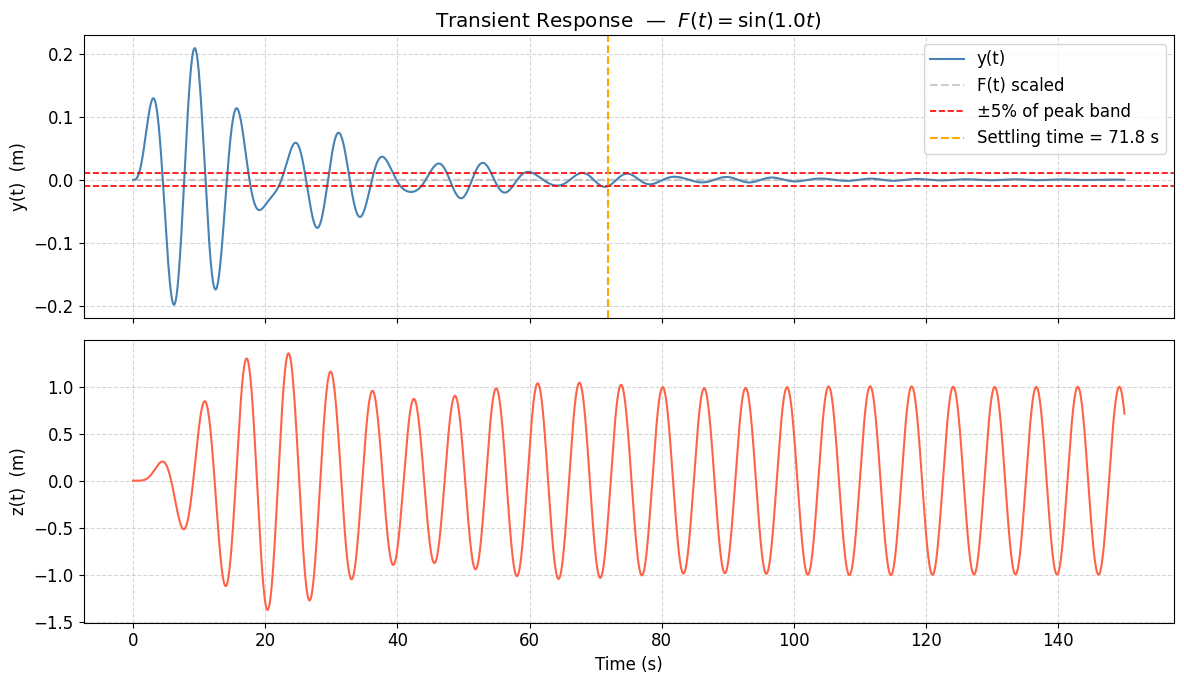

Steady-state amplitude of y:  0.0000 m
Peak amplitude of y:          0.2088 m
5% of peak (band width):      0.0104 m
5% settling time:             71.79 s


In [18]:
# Simulate long enough to reach steady state
t_end = 150
t = np.linspace(0, t_end, 15000)
F = np.sin(omega_f * t)

_, y_out = ctrl.forced_response(H_y, T=t, U=F)
_, z_out = ctrl.forced_response(H_z, T=t, U=F)

# Steady-state amplitude and 5% band based on peak (max) amplitude
A_ss  = abs(ctrl.evalfr(H_y, 1j * omega_f))
A_max = np.max(np.abs(y_out))
band_5pct = 0.05 * A_max

# Settling time: last moment the response exceeds A_ss ± 5% of peak
outside = np.where(np.abs(y_out) > A_ss + band_5pct)[0]
t_settle = t[outside[-1]] if len(outside) > 0 else 0.0

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# --- y(t) ---
axes[0].plot(t, y_out, color='steelblue', label='y(t)')
axes[0].plot(t, F * A_ss, '--', color='gray', alpha=0.4, label='F(t) scaled')
axes[0].axhline( A_ss + band_5pct, color='red', ls='--', lw=1.2, label='±5% of peak band')
axes[0].axhline(-(A_ss + band_5pct), color='red', ls='--', lw=1.2)
axes[0].axvline(t_settle, color='orange', ls='--', lw=1.5,
                label=f'Settling time = {t_settle:.1f} s')
axes[0].set_ylabel('y(t)  (m)')
axes[0].set_title(f'Transient Response  —  $F(t) = \\sin({omega_f}t)$')
axes[0].legend(loc='upper right')
axes[0].grid(True, ls='--', alpha=0.5)

# --- z(t) ---
axes[1].plot(t, z_out, color='tomato')
axes[1].set_ylabel('z(t)  (m)')
axes[1].set_xlabel('Time (s)')
axes[1].grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f'Steady-state amplitude of y:  {A_ss:.4f} m')
print(f'Peak amplitude of y:          {A_max:.4f} m')
print(f'5% of peak (band width):      {band_5pct:.4f} m')
print(f'5% settling time:             {t_settle:.2f} s')

## Step Response

In [ ]:
t_s, y_s = ctrl.step_response(H_y)

plt.figure()
plt.plot(t_s, y_s)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Step Response  —  Y/F')
plt.grid(True, ls='--', alpha=0.5)
plt.show()

## Pole-Zero Map

In [ ]:
plt.figure()
ctrl.pzmap(H_y, plot=True, title='Pole-Zero Map  —  Y/F')
plt.grid(True, ls='--', alpha=0.5)
plt.show()

## Bode Plot  —  Z/F

In [ ]:
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(10, 7))

omega = np.logspace(-1, 3, 1000)
mag_z, phase_z, omega_out_z = ctrl.bode(H_z, omega, plot=False)

# Magnitude
ax_mag.semilogx(omega_out_z, 20 * np.log10(mag_z))
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.set_title('Bode Plot  —  Z/F')
ax_mag.grid(True, which='both', ls='--', alpha=0.5)

# Phase
ax_phase.semilogx(omega_out_z, np.degrees(phase_z))
ax_phase.set_ylabel('Phase (deg)')
ax_phase.set_xlabel('Frequency (rad/s)')
ax_phase.grid(True, which='both', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Stability Margins

In [ ]:
gm, pm, wg, wp = ctrl.margin(H_y)
print(f'Gain Margin:   {20*np.log10(gm):.2f} dB  (at {wg:.2f} rad/s)')
print(f'Phase Margin:  {pm:.2f} deg  (at {wp:.2f} rad/s)')

## Problem 3

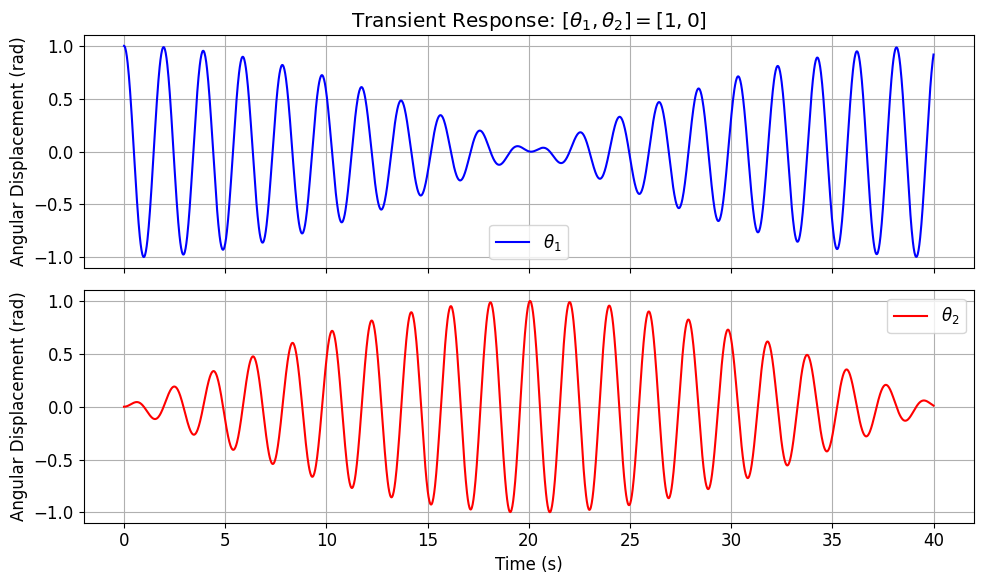

Natural frequencies: ω₁ = 3.1321 rad/s, ω₂ = 3.2879 rad/s


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
L = 1.0   # m
M = 1.0   # kg
K = 2.0   # N/m
g = 9.81  # m/s^2

# Mass and stiffness matrices
Mmat = np.array([[M*L**2, 0],
                 [0,      M*L**2]])

Kmat = np.array([[M*g*L + K*L**2/4, -K*L**2/4],
                 [-K*L**2/4,         M*g*L + K*L**2/4]])

Minv = np.linalg.inv(Mmat)

# State space: x = [theta1, theta2, dtheta1, dtheta2]
def equations(t, x):
    theta = x[:2]
    dtheta = x[2:]
    ddtheta = -Minv @ Kmat @ theta
    return np.concatenate([dtheta, ddtheta])

# Initial conditions [theta1, theta2, dtheta1, dtheta2]
x0 = [1.0, 0.0, 0.0, 0.0]

# Time span
t_span = (0, 40)
t_eval = np.linspace(0, 40, 2000)

# Solve
sol = solve_ivp(equations, t_span, x0, t_eval=t_eval, method='RK45', rtol=1e-9)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(sol.t, sol.y[0], label=r'$\theta_1$', color='blue')
axes[0].set_ylabel('Angular Displacement (rad)')
axes[0].set_title(r'Transient Response: $[\theta_1, \theta_2] = [1, 0]$')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(sol.t, sol.y[1], label=r'$\theta_2$', color='red')
axes[1].set_ylabel('Angular Displacement (rad)')
axes[1].set_xlabel('Time (s)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print natural frequencies
eigenvalues = np.linalg.eigvals(Minv @ Kmat)
omega_n = np.sqrt(np.sort(eigenvalues))
print(f"Natural frequencies: ω₁ = {omega_n[0]:.4f} rad/s, ω₂ = {omega_n[1]:.4f} rad/s")